In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def flat_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

In [2]:
trrs  = pd.read_csv('../final/tactical_response_reports.csv')
trrs_unique = trrs.drop_duplicates(subset='event_no')
trrs.columns

Index(['trr_id', 'rd_no', 'cr_no_obtained', 'subject_cb_no', 'event_no',
       'beat', 'block', 'street_direction', 'street_name', 'location', 'date',
       'time', 'indoor_or_outdoor', 'lighting_condition', 'weather_condition',
       'notify_oemc', 'notify_dist_sergeant', 'notify_op_command',
       'notify_det_div', 'number_of_weapons_discharged', 'party_fired_first',
       'duty_status', 'injured', 'member_in_uniform', 'subject_gender',
       'subject_race', 'subject_age', 'subject_birthyear', 'subject_armed',
       'subject_injured', 'subject_alleged_injury', 'uid'],
      dtype='object')

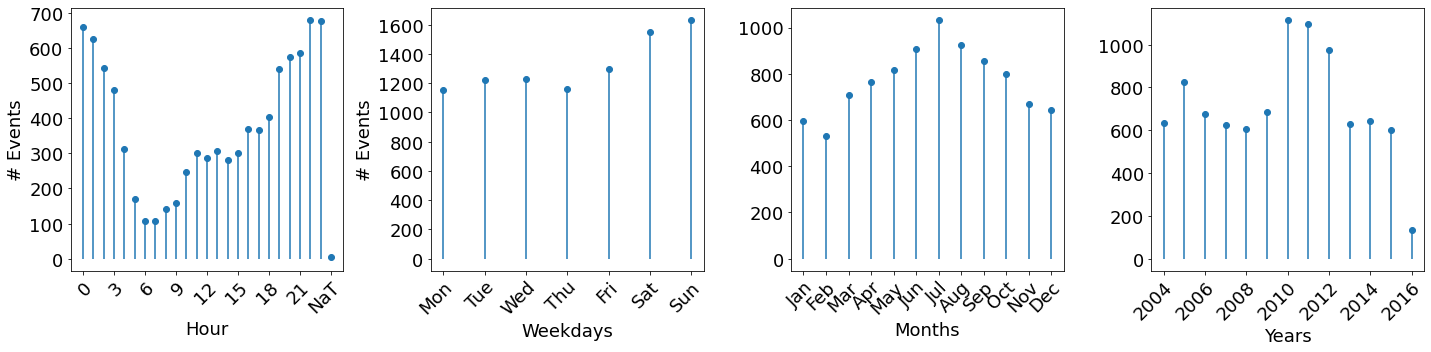

In [3]:
events_per_year = np.bincount(pd.to_datetime(trrs_unique['date'].values).year)[-13:]
events_per_month = np.bincount(pd.to_datetime(trrs_unique['date'].values).month)[1:]
events_per_day = np.bincount(pd.to_datetime(trrs_unique['date'].values).weekday)
hours = pd.to_datetime(trrs_unique['time'].values).hour
hours = np.nan_to_num(hours, nan=24)
events_per_hour = np.bincount(hours.astype(int))

plt.figure(figsize = (20,5))

ax=plt.subplot(141)

plt.scatter(np.arange(len(events_per_hour)), events_per_hour)
plt.vlines(x = np.arange(len(events_per_hour)), ymin = np.zeros(len(events_per_hour)), ymax = events_per_hour)
# dayticks = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
xrange = np.arange(len(events_per_hour))[::3]
xrangetikcs = [str(x) for x in xrange]
xrangetikcs[-1] = 'NaT'
plt.xticks(xrange, xrangetikcs, fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('# Events', fontsize = 18)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.xlabel('Hour', fontsize = 18)

ax=plt.subplot(142)

plt.scatter(np.arange(len(events_per_day)), events_per_day)
plt.vlines(x = np.arange(len(events_per_day)), ymin = np.zeros(len(events_per_day)), ymax = events_per_day)
dayticks = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(np.arange(len(events_per_day)), dayticks, fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('# Events', fontsize = 18)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.xlabel('Weekdays', fontsize = 18)

ax=plt.subplot(143)

plt.scatter(np.arange(len(events_per_month)), events_per_month)
plt.vlines(x = np.arange(len(events_per_month)), ymin = np.zeros(len(events_per_month)), ymax = events_per_month)
monthticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(len(events_per_month)), monthticks, fontsize = 18)
plt.yticks(fontsize = 18)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.xlabel('Months', fontsize = 18)

ax = plt.subplot(144)
plt.scatter(np.arange(2004, 2017, dtype = int), events_per_year)
plt.vlines(x = np.arange(2004, 2017, dtype = int), ymin = np.zeros(len(events_per_year)), ymax = events_per_year)
plt.xlabel('Years', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize = 18)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.tight_layout()
plt.savefig('../doc/figs/shooting_times.pdf', dpi=1000, bbox_inches = 'tight')
# plt.savefig('../doc/figs/shooting_times.png', dpi=100, bbox_inches = 'tight')
plt.show()

In [4]:
# type of trr
officer_injured_counts = trrs['injured'].value_counts()
subject_alleged_injured_counts = trrs_unique['subject_alleged_injury'].value_counts()
subject_injured_counts = trrs_unique['subject_injured'].value_counts()

fired_first = trrs_unique['party_fired_first'].value_counts()

subject_race = trrs_unique['subject_race'].value_counts()
subject_race = [subject_race[0], subject_race[1], subject_race[2], np.array(subject_race[3:]).sum()]

subject_gender = trrs_unique['subject_gender'].value_counts()
subject_armed = trrs_unique['subject_armed'].value_counts()

uids = trrs['uid']
roster = pd.read_csv('../final/roster.csv')
officer_gender = roster[roster['uid'].isin(uids)]['gender'].value_counts()
officer_race = roster[roster['uid'].isin(uids)]['race']

trrs['officer_race'] = [roster[roster['uid']==u]['race'].values[0] for u in uids]


trrs_race = trrs[['officer_race', 'subject_race']]
grouped_by_race = trrs_race.groupby(['officer_race', 'subject_race']).size()

In [5]:
officers_race = sorted(set([k[0] for k in grouped_by_race.keys()]))
officers_keys = {k:i for i,k in enumerate(officers_race)}
officers_keys_ticks = ['Am. Ind.', 'Asian', 'Black', 'White', 'Wh. Hisp.']

subject_race_ = sorted(set([k[1] for k in grouped_by_race.keys()]))
subject_keys = {k:i for i,k in enumerate(subject_race_)}

sj_ls = ['Black',  'White','Wh. Hisp.', 'Other']

subject_keys = {}
subject_keys['AMER IND/ALASKAN NATIVE'] = 3
subject_keys['ASIAN/PACIFIC ISLANDER'] = 3
subject_keys['BLACK'] = 0
subject_keys['BLACK HISPANIC'] = 3
subject_keys['UNKNOWN'] = 3
subject_keys['WHITE'] = 1
subject_keys['WHITE HISPANIC'] = 2

officer_subject_value_ls = []
for officer_subject, value in grouped_by_race.items():
    officer, subject = officer_subject[0], officer_subject[1]
    officer_subject_value_ls.append([officers_keys[officer], subject_keys[subject], value])

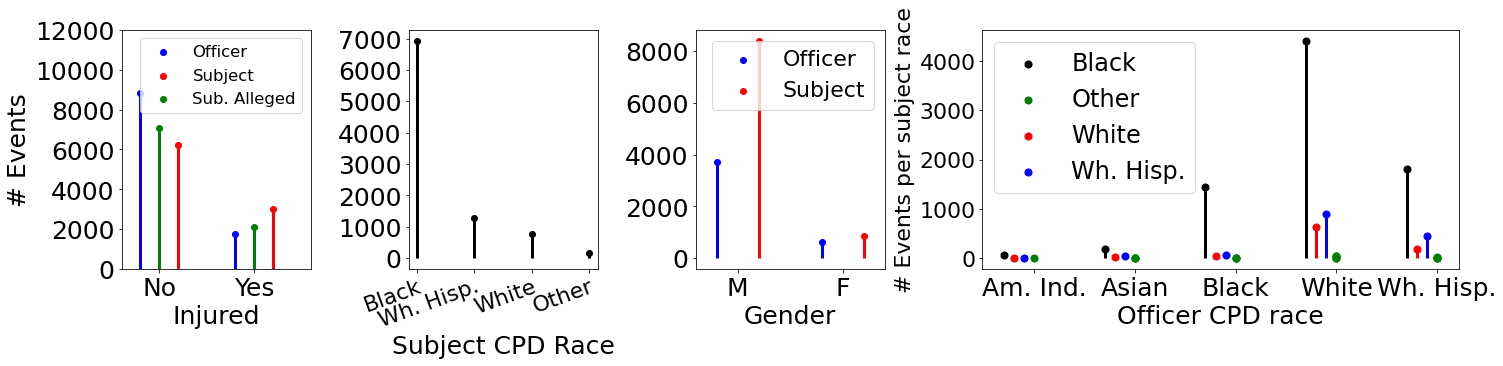

In [45]:
fig = plt.figure(figsize = (21,5))

gs=GridSpec(1,10) # 2 rows, 3 columns

ax1 = fig.add_subplot(gs[0,:2]) # First row, first column

plt.scatter(x = [-.2,.8], y = officer_injured_counts, color = 'b', label = 'Officer')
plt.vlines(x = [-.2,.8], ymin = np.zeros(len(officer_injured_counts)), ymax = officer_injured_counts, lw =3, color = 'b')

plt.scatter(x = [.2,1.2], y = subject_injured_counts, color = 'r', label = 'Subject')
plt.vlines(x = [.2,1.2], ymin = np.zeros(len(subject_injured_counts)), ymax = subject_injured_counts, lw =3, color = 'r')

plt.scatter(x = [0,1], y = subject_alleged_injured_counts, color = 'g', label = 'Sub. Alleged')
plt.vlines(x = [0,1], ymin = np.zeros(len(subject_alleged_injured_counts)), ymax = subject_alleged_injured_counts, lw =3, color = 'g')


plt.xlim([-.4,1.6])
plt.ylim([0,12000])
plt.xticks([0,1], [ 'No', 'Yes'], fontsize = 25) 
plt.yticks(fontsize =  15)
plt.ylabel('# Events', fontsize =  25)
plt.xlabel('Injured', fontsize = 25)
plt.yticks(fontsize = 25)

plt.legend(fontsize = 16.5, loc = 'upper right') #, bbox_to_anchor=(1, 0.5))



ax3 = fig.add_subplot(gs[0,2:4]) # First row, first column
plt.scatter(x = np.arange(len(subject_race)), y = subject_race, color = 'k')
plt.vlines(x = np.arange(len(subject_race)), ymin = np.zeros(len(subject_race)), ymax=  subject_race, lw = 3, color = 'k')

race_names = ['Black', 'Wh. Hisp.', 'White', 'Other']
other =[ 'Bl. Hisp.', 'Asian', 'Ukw.', 'Am. Ind.']
plt.xticks(np.arange(len(subject_race)), [race_name for r, race_name in enumerate(race_names)], fontsize = 22)
plt.yticks(fontsize =  15)
plt.xlabel('Subject CPD Race', fontsize = 25)
plt.setp( ax3.xaxis.get_majorticklabels(), rotation=20, ha="right", rotation_mode="anchor") 
plt.yticks(fontsize = 25)



ax3 = fig.add_subplot(gs[0,4:6]) # First row, first column

plt.scatter(x = [-.2,.8], y = officer_gender, color = 'b', label = 'Officer')
plt.vlines(x = [-.2,.8], ymin = np.zeros(len(officer_gender)), ymax=  officer_gender, color = 'b', lw = 3)


plt.scatter(x = [.2,1.2], y = subject_gender, color = 'r', label = 'Subject')
plt.vlines(x = [.2,1.2], ymin = np.zeros(len(subject_gender)), ymax=  subject_gender, color = 'r', lw = 3)

plt.xlim([-.4, 1.4])
plt.xticks([0,1], ['M', 'F'], fontsize = 25)
plt.xlabel('Gender', fontsize = 25)
plt.legend(fontsize = 22, loc = 'best')
plt.yticks(fontsize = 25)

ax4 = fig.add_subplot(gs[0,6:])

    
shift = [-.3, -.2, -.1, 0, .1, .2, .3]

colors = ['k', 'r', 'b', 'g', 'orange', 'purple', 'cyan']
included = []
for officer_subject_value in officer_subject_value_ls:
    officer, subject, value = officer_subject_value
    x = officer + shift[subject]
    y = value
    color = colors[subject]
    plt.vlines(x=x,ymin=0,ymax = y, color=color, lw =3)
    if subject not in included:
        included.append(subject)
        plt.scatter(x,y, color = color, label = sj_ls[subject], s= 50)
    else:
        plt.scatter(x,y, color = color, s = 50)
plt.legend(fontsize = 24)
plt.xticks(range(len(officers_keys)), officers_keys_ticks, fontsize = 25)
plt.xlabel('Officer CPD race', fontsize = 25)
plt.ylabel('# Events per subject race', fontsize = 22)
plt.yticks(fontsize = 22)


plt.tight_layout()
plt.savefig('../doc/figs/trr_stats.pdf', bbox_inches = 'tight', dpi = 1000)
plt.show()